Load preprocessed data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


dataF = np.loadtxt("dataF_final.csv", delimiter=",")   
dataC = np.loadtxt("dataC_final.csv", delimiter=",")   

print("Shapes:", dataF.shape, dataC.shape)

Shapes: (258, 1868) (258, 5)


Define VIP function

In [ ]:
def calculate_vip(pls_model, X, Y):
     
    t = pls_model.x_scores_         
    w = pls_model.x_weights_       
    q = pls_model.y_loadings_       

    p, h = w.shape                 
    n_targets = Y.shape[1]

     
    s = np.zeros((h,))
    for i in range(h):
        s[i] = np.sum(np.sum((t[:, i][:, None] ** 2) * (q[:, i][None, :] ** 2)))

    total_s = np.sum(s)

    vip = np.zeros((p,))
    for j in range(p):
        weight_sq = np.array([w[j, i]**2 * s[i] for i in range(h)])
        vip[j] = np.sqrt(p * np.sum(weight_sq) / total_s)

    return vip


Fit full PLS model

Here, a PLS model is trained on all features, and VIP scores are computed to measure each feature’s importance in predicting the targets.


In [ ]:
n_components = min(10, dataF.shape[0]-1)  
pls_full = PLSRegression(n_components=n_components)
pls_full.fit(dataF, dataC)

 
vip_scores = calculate_vip(pls_full, dataF, dataC)


Rank features by VIP

In [ ]:
feature_indices_sorted = np.argsort(vip_scores)[::-1]  
vip_sorted = vip_scores[feature_indices_sorted]



features_sorted = np.array([f"Feature_{i}" for i in range(dataF.shape[1])])[feature_indices_sorted]

for name, score in zip(features_sorted, vip_sorted):
    print(name, score)



Feature_1216 1.8157622765887604
Feature_1136 1.710571331910967
Feature_1839 1.7064249980171209
Feature_1135 1.6487631629356714
Feature_1215 1.6422976043857551
Feature_1539 1.62825896049704
Feature_1734 1.6060430746162957
Feature_1691 1.605727474248145
Feature_1338 1.5738129692265383
Feature_1314 1.55955862011001
Feature_1315 1.547999073093147
Feature_1114 1.5462639417238881
Feature_1822 1.5418654785274744
Feature_1538 1.5219804583301837
Feature_1316 1.5051235614537748
Feature_1752 1.4942515054511272
Feature_1272 1.4927986555391863
Feature_413 1.4917839475098464
Feature_1337 1.483729328672463
Feature_1329 1.482835816328474
Feature_1145 1.4726098339720968
Feature_1611 1.4668098131094722
Feature_1320 1.4666508024199334
Feature_1284 1.4634607068903076
Feature_1317 1.4614947379466516
Feature_1517 1.460828063186066
Feature_1226 1.4573917399969933
Feature_1516 1.4568648627777074
Feature_1273 1.456578074975574
Feature_1278 1.4544767526585736
Feature_1328 1.4497046893528973
Feature_1829 1.44498

Sequential RMSE computation

This code incrementally tests subsets of top-ranked features, fits a PLS model on each subset, computes RMSE, and prints the performance per subset.


In [ ]:
rmse_list = []
features_list = []

for i in range(1, dataF.shape[1]+1):   
    top_features = feature_indices_sorted[:i]
    X_subset = dataF[:, top_features]

    pls = PLSRegression(n_components=min(n_components, X_subset.shape[1]))
    pls.fit(X_subset, dataC)
    Y_pred = pls.predict(X_subset)

    rmse = np.sqrt(mean_squared_error(dataC, Y_pred))
    rmse_list.append(rmse)
    features_list.append(top_features)



 
for i, (rmse, feats) in enumerate(zip(rmse_list, features_list), start=1):
    print(f"Top {i} features -> RMSE: {rmse:.4f}, Features: {feats}")


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Top 1 features -> RMSE: 1980.9061, Features: [1216]
Top 2 features -> RMSE: 1979.3580, Features: [1216 1136]
Top 3 features -> RMSE: 1950.0626, Features: [1216 1136 1839]
Top 4 features -> RMSE: 1941.8342, Features: [1216 1136 1839 1135]
Top 5 features -> RMSE: 1927.9043, Features: [1216 1136 1839 1135 1215]
Top 6 features -> RMSE: 1926.7038, Features: [1216 1136 1839 1135 1215 1539]
Top 7 features -> RMSE: 1919.1819, Features: [1216 1136 1839 1135 1215 1539 1734]
Top 8 features -> RMSE: 1896.1914, Features: [1216 1136 1839 1135 1215 1539 1734 1691]
Top 9 features -> RMSE: 1894.0125, Features: [1216 1136 1839 1135 1215 1539 1734 1691 1338]
Top 10 features -> RMSE: 1874.2564, Features: [1216 1136 1839 1135 1215 1539 1734 1691 1338 1314]
Top 11 features -> RMSE: 1872.2561, Features: [1216 1136 1839 1135 1215 1539 1734 1691 1338 1314 1315]
Top 12 features -> RMSE: 1867.4335, Features: [1216 1136 1839 1135 1215 1539 1734 1691 1338 1314 1315 1114]
Top 13 features -> RMSE: 1828.5828, Feature

Find first minimum RMSE

In [9]:
rmse_array = np.array(rmse_list)
first_min_idx = np.argmin(rmse_array)
optimal_features = feature_indices_sorted[:first_min_idx + 1]

print("Optimal number of features:", len(optimal_features))
print("Indices of selected features:", optimal_features)
print("Minimum RMSE:", rmse_array[first_min_idx])

Optimal number of features: 1844
Indices of selected features: [1216 1136 1839 ... 1503 1550 1499]
Minimum RMSE: 1054.693645788353


Plot RMSE vs number of features

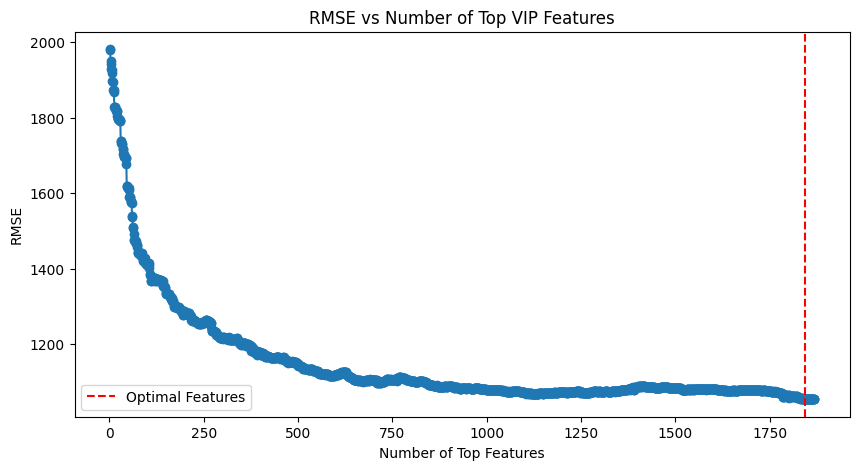

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmse_list)+1), rmse_list, marker='o')
plt.axvline(x=len(optimal_features), color='r', linestyle='--', label='Optimal Features')
plt.title("RMSE vs Number of Top VIP Features")
plt.xlabel("Number of Top Features")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Fit final PLS model using optimal features

In [11]:
X_final = dataF[:, optimal_features]
pls_final = PLSRegression(n_components=min(n_components, X_final.shape[1]))
pls_final.fit(X_final, dataC)
Y_final_pred = pls_final.predict(X_final)

final_rmse = np.sqrt(mean_squared_error(dataC, Y_final_pred))
print("Final RMSE with selected features:", final_rmse)

Final RMSE with selected features: 1054.693645788353


evaluation

Target 1: R² = 0.7102
Target 2: R² = 0.7434
Target 3: R² = 0.7182
Target 4: R² = 0.7180
Target 5: R² = 0.6269


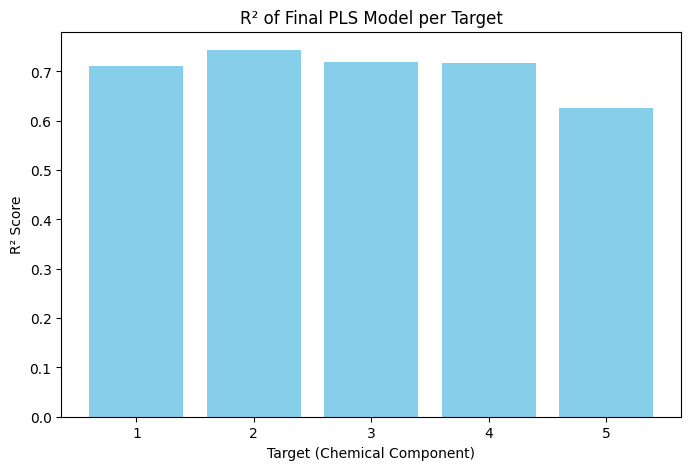

In [ ]:
from sklearn.metrics import r2_score

 
n_targets = dataC.shape[1]
r2_scores = []

for i in range(n_targets):
    r2 = r2_score(dataC[:, i], Y_final_pred[:, i])
    r2_scores.append(r2)
    print(f"Target {i+1}: R² = {r2:.4f}")

 
plt.figure(figsize=(8, 5))
plt.bar(range(1, n_targets+1), r2_scores, color='skyblue')
plt.xticks(range(1, n_targets+1))
plt.xlabel("Target (Chemical Component)")
plt.ylabel("R² Score")
plt.title("R² of Final PLS Model per Target")
plt.show()


RMSE and REP 

Target 1: RMSE = 1012.6231, REP = 2.78%
Target 2: RMSE = 1505.1156, REP = 4.33%
Target 3: RMSE = 709.2168, REP = 6.94%
Target 4: RMSE = 1329.7087, REP = 4.20%
Target 5: RMSE = 1.1033, REP = 9.81%


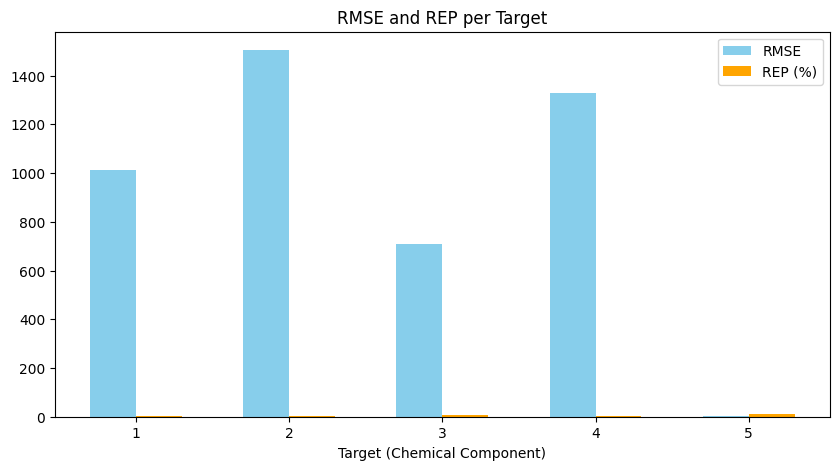

In [ ]:
import numpy as np

n_targets = dataC.shape[1]
rmse_list = []
rep_list = []

for i in range(n_targets):
    y_true = dataC[:, i]
    y_pred = Y_final_pred[:, i]
    
    
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    rmse_list.append(rmse)
    
    
    rep = np.sqrt(np.sum((y_true - y_pred)**2)) / np.sum(y_true) * 100
    rep_list.append(rep)
    
    print(f"Target {i+1}: RMSE = {rmse:.4f}, REP = {rep:.2f}%")

 
plt.figure(figsize=(10,5))
x = np.arange(1, n_targets+1)
plt.bar(x-0.15, rmse_list, width=0.3, label="RMSE", color='skyblue')
plt.bar(x+0.15, rep_list, width=0.3, label="REP (%)", color='orange')
plt.xticks(x)
plt.xlabel("Target (Chemical Component)")
plt.title("RMSE and REP per Target")
plt.legend()
plt.show()


This code performs Ridge regression with cross-validated alpha on selected features, predicts targets, computes R², RMSE, REP%, and visualizes the R² scores per target.


Best alpha found: 100
Target 1:
  R²   = 0.9619
  RMSE = 367.2235
  REP% = 16.22%

Target 2:
  R²   = 0.9654
  RMSE = 552.9503
  REP% = 25.54%

Target 3:
  R²   = 0.9675
  RMSE = 240.6943
  REP% = 37.81%

Target 4:
  R²   = 0.9602
  RMSE = 499.4308
  REP% = 25.31%

Target 5:
  R²   = 0.9474
  RMSE = 0.4141
  REP% = 59.13%



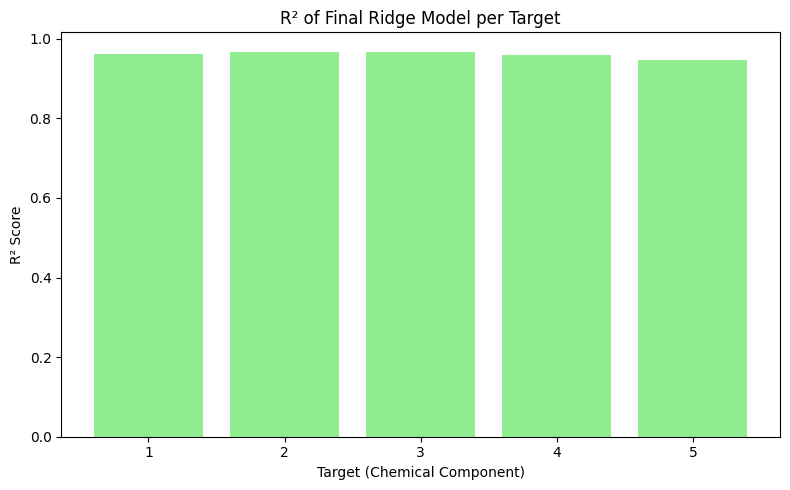

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
 
X_final = dataF[:, optimal_features]   
Y_final = dataC

 
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_final)

 
Y_mean = np.mean(Y_final, axis=0)
Y_std = np.std(Y_final, axis=0)
Y_scaled = (Y_final - Y_mean) / Y_std

 
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = GridSearchCV(Ridge(), param_grid={'alpha': alphas}, cv=5, scoring='r2')
ridge_cv.fit(X_scaled, Y_scaled)
best_alpha = ridge_cv.best_params_['alpha']
print("Best alpha found:", best_alpha)

 
ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(X_scaled, Y_scaled)
Y_pred_scaled = ridge_final.predict(X_scaled)

 
Y_pred_final = Y_pred_scaled * Y_std + Y_mean

 
r2_list, rmse_list, rep_list = [], [], []

for col in range(Y_final.shape[1]):
    y_true = Y_final[:, col]
    y_pred = Y_pred_final[:, col]

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rep = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan

    r2_list.append(r2)
    rmse_list.append(rmse)
    rep_list.append(rep)
 
for idx in range(Y_final.shape[1]):
    print(f"Target {idx+1}:")
    print(f"  R²   = {r2_list[idx]:.4f}")
    print(f"  RMSE = {rmse_list[idx]:.4f}")
    print(f"  REP% = {rep_list[idx]:.2f}%\n")

plt.figure(figsize=(8, 5))
plt.bar(range(1, Y_final.shape[1] + 1), r2_list, color='lightgreen')
plt.xticks(range(1, Y_final.shape[1] + 1))
plt.xlabel("Target (Chemical Component)")
plt.ylabel("R² Score")
plt.title("R² of Final Ridge Model per Target")
plt.tight_layout()
plt.show()


This code fits a Lasso regression on selected features for each target, computes R², RMSE, REP%, and visualizes the R² scores per target.


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e+06, tolerance: 2.278e+05
  model = cd_fast.enet_coordinate_descent(


Target 1:
  R²   = 0.9683
  RMSE = 334.8407
  REP% = 14.79%

Target 2:
  R²   = 0.9825
  RMSE = 392.8315
  REP% = 18.14%

Target 3:
  R²   = 0.9559
  RMSE = 280.4260
  REP% = 44.05%

Target 4:
  R²   = 0.9777
  RMSE = 374.0845
  REP% = 18.96%

Target 5:
  R²   = 0.0000
  RMSE = 1.8062
  REP% = 257.94%



C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.726e+05, tolerance: 1.618e+05
  model = cd_fast.enet_coordinate_descent(


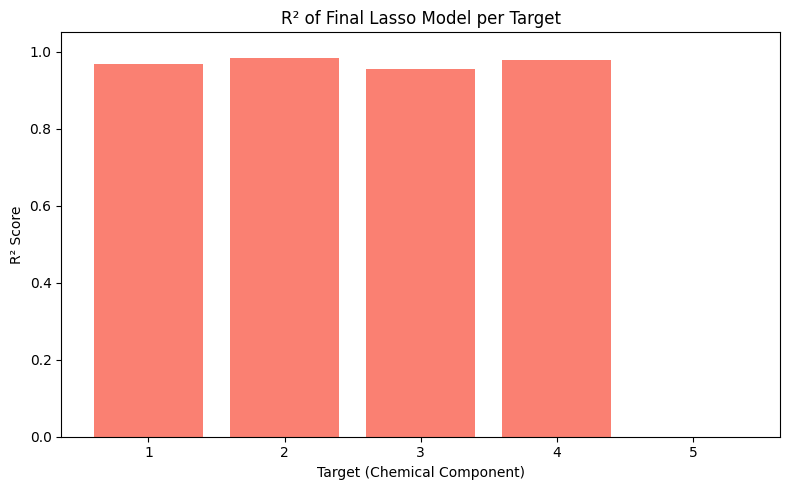

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

 
X_final = dataF[:, optimal_features]   
Y_final = dataC   

 
r2_list = []
rmse_list = []
rep_list = []

 
for col in range(Y_final.shape[1]):
    y_true = Y_final[:, col]

     
    lasso = Lasso(alpha=0.01, max_iter=10000)   
    lasso.fit(X_final, y_true)

     
    y_pred = lasso.predict(X_final)

     
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_val = np.mean(y_true)
    rep = (rmse / mean_val) * 100 if mean_val != 0 else np.nan

    r2_list.append(r2)
    rmse_list.append(rmse)
    rep_list.append(rep)

 
for idx in range(Y_final.shape[1]):
    print(f"Target {idx+1}:")
    print(f"  R²   = {r2_list[idx]:.4f}")
    print(f"  RMSE = {rmse_list[idx]:.4f}")
    print(f"  REP% = {rep_list[idx]:.2f}%\n")

 
plt.figure(figsize=(8, 5))
plt.bar(range(1, Y_final.shape[1] + 1), r2_list, color='salmon')
plt.xticks(range(1, Y_final.shape[1] + 1))
plt.xlabel("Target (Chemical Component)")
plt.ylabel("R² Score")
plt.title("R² of Final Lasso Model per Target")
plt.ylim(0, 1.05)  # optional: keep consistent y-axis
plt.tight_layout()
plt.show()


Here an ElasticNet regression is applied to the selected features for each target, and the code evaluates and visualizes its predictive performance using R², RMSE, and REP%.


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e+06, tolerance: 9.129e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.740e+06, tolerance: 2.278e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

Target 1:
  R²   = 0.9999
  RMSE = 21.2918
  REP% = 0.94%

Target 2:
  R²   = 0.9991
  RMSE = 90.4791
  REP% = 4.18%

Target 3:
  R²   = 1.0000
  RMSE = 5.6697
  REP% = 0.89%

Target 4:
  R²   = 0.9991
  RMSE = 75.6791
  REP% = 3.84%

Target 5:
  R²   = 0.9920
  RMSE = 0.1611
  REP% = 23.01%



C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.184e-01, tolerance: 8.417e-02
  model = cd_fast.enet_coordinate_descent(


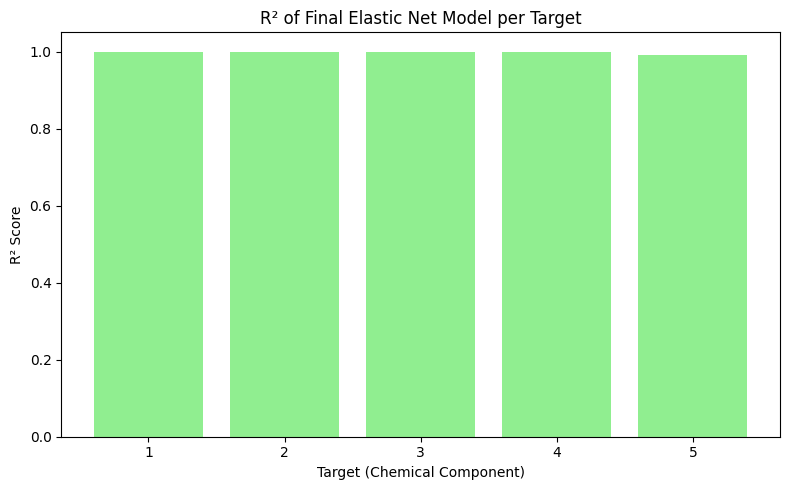

In [ ]:
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


X_final = dataF[:, optimal_features]   
Y_final = dataC


 
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final)


elastic_final = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000)

Y_pred_final = np.zeros_like(Y_final)

for col in range(Y_final.shape[1]):
    y_true = Y_final[:, col]
    elastic_final.fit(X_final_scaled, y_true)
    Y_pred_final[:, col] = elastic_final.predict(X_final_scaled)

 
r2_list, rmse_list, rep_list = [], [], []

for col in range(Y_final.shape[1]):
    y_true = Y_final[:, col]
    y_pred = Y_pred_final[:, col]

 
    r2 = r2_score(y_true, y_pred)

 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

   
    mean_val = np.mean(y_true)
    rep = (rmse / mean_val) * 100 if mean_val != 0 else np.nan

    r2_list.append(r2)
    rmse_list.append(rmse)
    rep_list.append(rep)
 
for idx in range(Y_final.shape[1]):
    print(f"Target {idx+1}:")
    print(f"  R²   = {r2_list[idx]:.4f}")
    print(f"  RMSE = {rmse_list[idx]:.4f}")
    print(f"  REP% = {rep_list[idx]:.2f}%\n")



 
plt.figure(figsize=(8, 5))
plt.bar(range(1, Y_final.shape[1] + 1), r2_list, color='lightgreen')
plt.xticks(range(1, Y_final.shape[1] + 1))
plt.xlabel("Target (Chemical Component)")
plt.ylabel("R² Score")
plt.title("R² of Final Elastic Net Model per Target")
plt.ylim(0, 1.05)   
plt.tight_layout()
plt.show()
